# Scripts for CPlantBox

 [CPlantBox](https://github.com/Plant-Root-Soil-Interactions-Modelling/CPlantBox) is a functional structural plant model. It is currently underconstruction. But some of the functions are already working. There are serveral ways to use the CPlantBox, which are:
 1. Python Scripts.
 2. C++ source file for building and compiling.
 3. Precompiled programm for windows.
 4. Online usage.
Among them the the python scripting is the recommended and most robust way to use it. In this notebook, we can see how they work and what can we learn from them. This notebook is based on a tutorial written by [Daniel Leitner](http://www.simwerk.at/contact/) for CRootBox.

## 1.Read parameter file and generate a simple output

In line7, we could change the parameter name inside the qoutation marks, if we want to use different parameter. Normally we use the XML based parameter file. If you are using a .rparam file frome the CRootBox, you can directly use them here, but after the first run the new Parameter file is generated, and you can further use the new file later on.

In [2]:
import py_plantbox as pb # Open  and root parameter from a file
from rb_tools import *

plant = pb.Plant()

# Open  and root parameter from a file
name = "CPlantBox_test_leaf_tree" # you can change it to the name of other XML parameter files for example""
plant.openXML(name)

# Initialize
plant.initialize()

# Simulate
plant.simulate(60, True)

# Export final result (as vtp)
#2 = root
#4 = stem
#8 = leaf
#15 = all

plant.write("results/example_1a.vtp", 15)


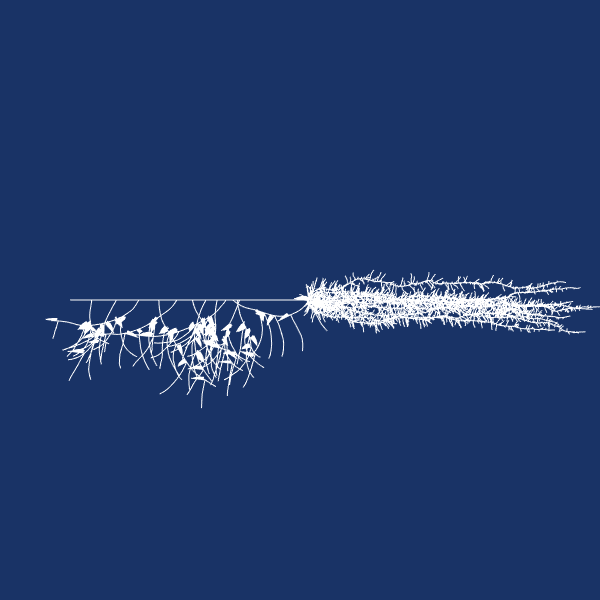

In [48]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/example_1a.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(500, 10, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )


iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    
renWin.Render()

windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()


writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))

Image(data)

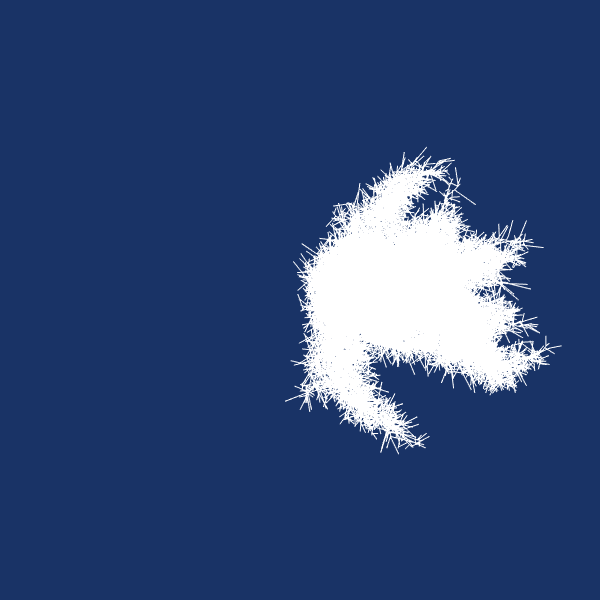

In [52]:
import vtk
from vtk import *
from IPython.display import Image

reader = vtk.vtkXMLPolyDataReader()
path = "results/example_5a.vtp" #path or name of the vtp output
reader.SetFileName(path)
reader.Update()
 
mapper = vtk.vtkPolyDataMapper()
mapper.SetInputData(reader.GetOutput())
 
plantActor = vtk.vtkActor()
plantActor.SetMapper( mapper )

camera =vtkCamera()
camera.SetPosition(100, 100, 0)
camera.SetFocalPoint(0, 0, 0)   

ren1= vtk.vtkRenderer()
ren1.AddActor( plantActor )
ren1.SetActiveCamera(camera)
ren1.SetBackground( 0.1, 0.2, 0.4 )


renWin = vtk.vtkRenderWindow()
renWin.AddRenderer( ren1 )
renWin.SetSize( 600, 600 )

 

iren = vtk.vtkRenderWindowInteractor()
iren.SetRenderWindow(renWin)
    

renWin.Render()


windowToImageFilter = vtkWindowToImageFilter()
windowToImageFilter.SetInput(renWin)
windowToImageFilter.Update()

 

writer = vtkPNGWriter()
writer.SetWriteToMemory(1)
writer.SetInputConnection(windowToImageFilter.GetOutputPort())
writer.Write()
data = bytearray(memoryview(writer.GetResult()))




Image(data)






In [46]:
import webbrowser

display(webbrowser.open('http://xrzhou.com/content/vtkjs/GeometryViewer/GeometryViewer.html?fileURL=http://xrzhou.com/content/1-projects/example_5a.vtp'))

True

In [1]:

from IPython.display import HTML
HTML('<iframe width="560" height="315" src="http://xrzhou.com/content/vtkjs/GeometryViewer/GeometryViewer.html?fileURL=http://xrzhou.com/content/1-projects/example_5a.vtp" frameborder="0" allowfullscreen></iframe>')